# 1. Statement

<hr>

Here I'll create a recommender system to recommend movies based on genre preference and movie popularity according to the [Letterboxd dataset from Kaggle](https://www.kaggle.com/datasets/samlearner/letterboxd-movie-ratings-data/data). This approach works well for cold-starts, and we'll test out some "new users" to our system who have no ratings for movies, but only genre preferences. 

<br>
<br>
<hr>

# 2. EDA

<hr>

We'll only be using one of the CSVs present in this dataset collection, just the movie_data.csv. That CSV file will be parsed into a Pandas DataFrame with the following columns:
- _id
- genres
- image_url
- imdb_id
- imdb_link
- movie_id
- movie_title
- original_language
- overview
- popularity
- production_countries
- release_date
- runtime
- spoken_languages
- tmdb_id
- tmdb_link
- vote_average
- vote_count
- year_released

We'll only be using a handful of these columns, but the analysis could be expanded primarily for localization.

We'll be dropping any duplicates of movie_title, and filling in any NA values with zeros.

Here are the columns we'll keep:
- genres
- image_url
- movie_id
- movie_title
- popularity
- vote_average
- vote_count

Genres is a string value, which appears as a list of other string values. Later those will be parsed into an actual list for better readability.
Image URL is kept so that the poster images can be used, but the "URLs" are incomplete slugs that cannot be retrieved by a simple GET request call.
Movie ID is the unique identifier for the movie.
Movie Title is the name of the movie.
Popularity is a a float value from TMDB to represent how popular the movie is.
Vote average and vote count come from user ratings, showing the total count of ratings and their average score.

<br>
<br>
<hr>

In [30]:
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install umap-learn
%pip install requests

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached charset_normalizer-3.4.2-cp39-cp39-macosx_10_9_universal2.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached certifi-2025.6.15-py3-none-any.whl.metadata (2.4 kB)
Using cached requests-2.32.4-py3-none-any.whl (64 kB)
Using cached charset_normalizer-3.4.2-cp39-cp39-macosx_10_9_universal2.whl (201 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached certifi-2025.6.15-py3-none-any.whl (157 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [requests]
Note: you may n

In [34]:
import pandas as pd

raw_movie_df = pd.read_csv("data/movie_data.csv")

In [3]:
print(raw_movie_df.columns)

Index(['_id', 'genres', 'image_url', 'imdb_id', 'imdb_link', 'movie_id',
       'movie_title', 'original_language', 'overview', 'popularity',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'tmdb_id', 'tmdb_link', 'vote_average', 'vote_count', 'year_released'],
      dtype='object')


# 3. Preprocessing

<hr>

Here's where the preprocessing takes place. The cleaning is perfrmed, removing the unneeded columns, filling in NA values, and removing duplicates.

Then the genre factorization takes place. They are unwrapped from their string format, converted into a list, and then only valid string values are added to the genre list.

A "weight" column is added to aggregate the popularity, vote_average, and vote_count values multiplied by a hyperparameter. This will later be used in the recommender.

The genre matrix will be defined as such: 1 row = 1 movie, 1 column = 1 genre. The cells of the matrix will be either a value of 0 or 1 to indicate if that movie represents the genre. Additional analysis could review the "overview" column and try to interpret genre from tokenizing the description.

<br>
<br>
<hr>

In [4]:
movie_columns = ["movie_id", "movie_title", "genres", "image_url", 
                 "popularity", "vote_average", "vote_count"]
movie_df = raw_movie_df[movie_columns]
unique_columns = ["movie_id", "movie_title", "image_url"]
movie_df = movie_df.drop_duplicates(subset="movie_title")
movie_df = movie_df.fillna(0)

In [5]:
def sanitize_genres(genre_value):
    import ast
    if isinstance(genre_value, str):
        trimmed = genre_value.replace('""', '"')
        try:
            genre_list = ast.literal_eval(trimmed)
            output = []
            for genre in genre_list:
                if isinstance(genre, str):
                    output.append(genre)
            return output
        except:
            return []
    return []

def encode_genre(genre, genre_list):
    return int(genre in genre_list)

movie_df["genres_list"] = movie_df["genres"].apply(sanitize_genres)

all_genres = sorted({ genre for genres in movie_df["genres_list"] for genre in genres })
for genre in all_genres:
    movie_df[genre] = movie_df["genres_list"].apply(
        lambda genre_list: encode_genre(genre, genre_list))

movie_df = movie_df.drop(columns=["genres", "genres_list"])

In [6]:
print(movie_df.shape)
print(movie_df.columns)

(244279, 25)
Index(['movie_id', 'movie_title', 'image_url', 'popularity', 'vote_average',
       'vote_count', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western'],
      dtype='object')


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
movie_df[["popularity", "vote_average", "vote_count"]] = scaler.fit_transform(
    movie_df[["popularity", "vote_average", "vote_count"]]
)

movie_df["weight"] = (
    0.2 * movie_df["popularity"] + 
    0.2 * movie_df["vote_average"] + 
    0.6 * movie_df["vote_count"]
)

In [8]:
import numpy as np
from scipy.sparse import csr_matrix

genre_matrix = csr_matrix(movie_df.iloc[:, 6:-1].values.astype(np.float32))

# 4. Model

<hr>

Here we can take a visual look at our model, displayed as clusters. I'm using the KMeans clustering method and UMAP dimension reduction technique. I have arbitrarily selected the number of clusters to be 7, as many genres have significant overlap (Adventure + Fantasy, Drama + Romance, Western + Action for some examples).

Taking a look at the plot, there are some well-defined clusters (islands) and many points that are not well-defined within a single cluster. There are also separate clusters of the same topic.

<br>
<br>
<hr>

/Users/mikebrozowski/movie-recommendation/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mikebrozowski/movie-recommendation/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/mikebrozowski/movie-recommendation/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/mikebrozowski/movie-recommendation/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/mikebrozowski/movie-recommendation/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: Use

<Axes: title={'center': 'Movie Genre Clusters'}, xlabel='x', ylabel='y'>

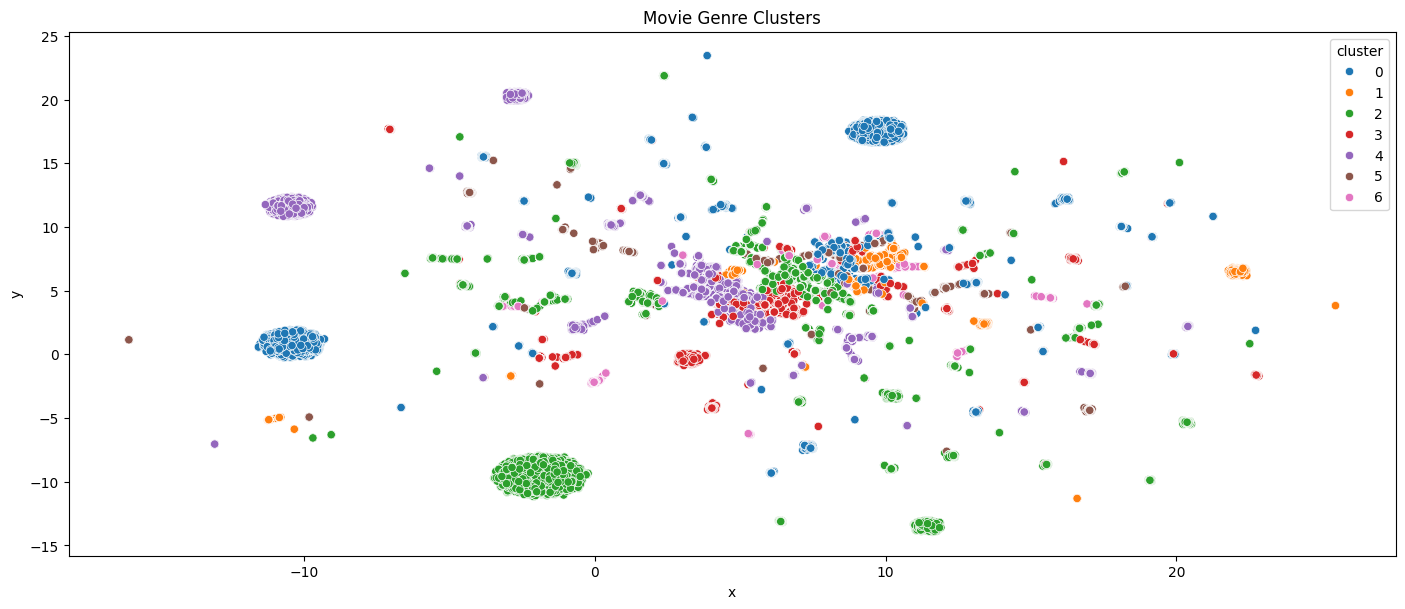

In [9]:
from sklearn.cluster import KMeans
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

n_clusters = 7
kmeans_model = KMeans(n_clusters=n_clusters, random_state=111)
labels = kmeans_model.fit_predict(genre_matrix)

reduction_model = UMAP(n_components=2, random_state=222)
reduction_projection = reduction_model.fit_transform(genre_matrix)

plot_df = pd.DataFrame(reduction_projection, columns=["x", "y"])
plot_df["cluster"] = labels

plt.figure(figsize=(14, 6))
plt.title("Movie Genre Clusters")
plt.tight_layout()
sns.scatterplot(
    data=plot_df,
    x="x",
    y="y",
    hue="cluster",
    palette="tab10",
)

# 5. Evaluation

<hr>

Here's the part where can actually use the recommendations. The number of movies in this dataset is immense (280,000+) so a complete similarity matrix would require hundreds of gigabytes of memory. So instead of calculating an entire similarity matrix, we can just get the top-k recommendations for our new "user".

I've manually added two users from real people and how they rate genres. For this recommendation system, the genre is equally as important as the popularity of the movie, but the genre preference plays a big part. Rather than keeping the genre preference on a scale of 1 to 5, I want to consider a rating of a 1 as a "I never, ever want to see a movie of this type". So, with that in mind, let's map that 1 to a 0 so it is not recommended at all. I've also expanded the difference between the other values to be exponential. So the genre rating inputs will be processed so that 1 is subtracted from their rating, and then their difference is squared.

- 1 -> 0
- 2 -> 1
- 3 -> 4
- 4 -> 9
- 5 -> 16

For readability, I've printed out the user genre preference next to the genre label and printed out the top 35 recommendations I have for that user. I played with the hyperparameters for some time and checked with the real user who represents those values if the recommendations were accurate enough.

<br>
<br>
<hr>

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def get_recommendations(user, genre_matrix, movie_df, k=20):
    genre_importance = 0.5
    popularity_importance = 0.5
    user_vector = (np.array(user) - 1) ** 2
    similarity_scores = cosine_similarity([user_vector], genre_matrix).flatten()
    weighted_scores = (genre_importance * similarity_scores + 
        popularity_importance * movie_df["weight"])
    indexes = weighted_scores.argsort()[-k:][::-1]
    return movie_df.iloc[indexes][["movie_title", "image_url"]]

In [ ]:
import numpy as np

user_1 = [3, 4, 2, 2, 1, 1, 4, 2, 4, 2, 5, 1, 5, 2, 5, 1, 5, 2, 4]
user_2 = [5, 5, 3, 5, 3, 5, 5, 3, 3, 5, 1, 3, 5, 3, 5, 3, 2, 2, 3]

user_1_rec = get_recommendations(user_1, genre_matrix, movie_df, 35)
user_2_rec = get_recommendations(user_2, genre_matrix, movie_df, 35)


print(list(zip(movie_df.iloc[:, 6:-1].columns.to_list(), user_1)))
print(np.array(user_1_rec["movie_title"]))

print("\n")

print(list(zip(movie_df.iloc[:, 6:-1].columns.to_list(), user_2)))
print(np.array(user_2_rec["movie_title"]))

[('Action', 3), ('Adventure', 4), ('Animation', 2), ('Comedy', 2), ('Crime', 1), ('Documentary', 1), ('Drama', 4), ('Family', 2), ('Fantasy', 4), ('History', 2), ('Horror', 5), ('Music', 1), ('Mystery', 5), ('Romance', 2), ('Science Fiction', 5), ('TV Movie', 1), ('Thriller', 5), ('War', 2), ('Western', 4)]
['Interstellar' 'Inception' 'Shutter Island' 'The Maze Runner'
 'World War Z' 'The Avengers' 'Gone Girl' 'Jurassic World'
 'Avengers: Infinity War' 'The Dark Knight' 'Guardians of the Galaxy'
 'Limitless' 'Happy Horror Days' 'A Cure for Wellness' 'The Prestige'
 'Sleepy Hollow' 'The Hunger Games' 'Gravity'
 'The Hunger Games: Mockingjay - Part 1' 'I Am Legend' 'Iron Man'
 '10 Cloverfield Lane' 'The Curse of Snake Valley' 'The Thing'
 'Twelve Monkeys' 'Forbidden Empire' 'Source Code' 'The Conjuring 2'
 'Black Swan' 'Riparian' 'Get Off My Porch' 'The Others' 'The Forgotten'
 'Digging Up the Marrow' 'Doctor Strange']


[('Action', 5), ('Adventure', 5), ('Animation', 3), ('Comedy', 5), 

# 6. Conclusion

<hr>

Working with the hyperparamters is key to getting a consistently good recommendation system. As I've explained above, other fields could be used to help improve or fill in some gaps for these recommendations. The "overview" column, for example, can be tokenized and treated as another similarity value between movies, so if a movie is highly recommended to them, it could use that similarity to suggest another. Localization plays a large factor here as well, with production countries, languages, etc. all playing a factor into personal and cultural preferences. 

Overall, I'm happy with this recommendation system and now my two real users have a few recommendations for new movies to see. Since this is a clustering approach, I couldn't evaluate this with a confusion matrix or accuracy metrics.

<br>
<br>
<hr>